# AR Segmentation Tutorial for Beginners 🌞

This notebook will guide you through running Active Region (AR) segmentation on solar images using the Surya model. 

## What you'll learn:
- How to load a pre-trained model for solar AR segmentation
- How to run inference on solar data
- How to visualize the results

## Prerequisites:
- Make sure you're in the correct directory: `downstream_examples/ar_segmentation/`
- Ensure all required packages are installed (torch, yaml, matplotlib, sunpy, etc.)

Let's get started! 🚀


In [2]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download

# Import functions from our inference script
from infer import (
    get_model, 
    apply_peft_lora, 
    load_model, 
    run_inference,
    get_dataloader,
    infer_single_sample
)

# Import from surya
from surya.utils.data import build_scalers
from surya.utils.distributed import set_global_seed

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


✅ All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA H100 80GB HBM3


## Step 2: Download Pre-trained Model Weights

The model weights will be automatically downloaded from Hugging Face. This might take a few minutes on first run.


In [3]:
# Download model weights from Hugging Face
print("📥 Downloading model weights...")
snapshot_download(
    repo_id="nasa-ibm-ai4science/ar_segmentation_surya",
    local_dir="./assets",
    allow_patterns='*.pth',
    token=None,
)
print("✅ Model weights downloaded successfully!")


📥 Downloading model weights...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 463.66it/s]

✅ Model weights downloaded successfully!


## Step 3: Set Up Configuration

We need to load the configuration file that contains all the model and data parameters. Make sure you have a `config.yaml` file in your current directory.


In [4]:
# Configuration paths - modify these if your files are in different locations
config_path = "./config.yaml"
checkpoint_path = "./assets/ar_segmentation_weights.pth"
output_dir = "./inference_results"

# Set global seed for reproducibility
set_global_seed(42)

# Load configuration
print("📋 Loading configuration...")
try:
    config = yaml.safe_load(open(config_path, "r"))
    config["data"]["scalers"] = yaml.safe_load(open(config["data"]["scalers_path"], "r"))
    print("✅ Configuration loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Make sure config.yaml exists in your current directory")
    raise

# Set data type (float precision)
if config["dtype"] == "float16":
    config["dtype"] = torch.float16
elif config["dtype"] == "bfloat16":
    config["dtype"] = torch.bfloat16
elif config["dtype"] == "float32":
    config["dtype"] = torch.float32
else:
    raise NotImplementedError("Please choose from [float16,bfloat16,float32]")

print(f"Model type: {config['model']['model_type']}")
print(f"Data precision: {config['dtype']}")


📋 Loading configuration...
✅ Configuration loaded successfully!
Model type: spectformer_lora
Data precision: torch.bfloat16


## Step 4: Set Up Device (GPU/CPU)

Let's determine whether to use GPU or CPU for inference. GPU is much faster if available!


In [5]:
# Set device - automatically use GPU if available, otherwise CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device("cpu")
    print("🐌 Using CPU (this will be slower)")
    print("💡 Tip: Consider using a machine with GPU for faster inference")


🚀 Using GPU: NVIDIA H100 80GB HBM3
GPU Memory: 85.0 GB


## Step 5: Run Inference (Easy Method)

This is the simplest way to run inference. The `run_inference` function handles everything for you!


In [6]:
# Parameters for inference
data_type = "test"  # or "valid" - which dataset to use
num_viz_samples = 2  # Number of samples to process and visualize

print("🔬 Starting AR segmentation inference...")
print(f"📊 Processing {num_viz_samples+1} samples")
print(f"📁 Results will be saved to: {output_dir}")

# Run the complete inference pipeline
try:
    run_inference(
        config=config,
        checkpoint_path=checkpoint_path,
        output_dir=output_dir,
        device=device,
        data_type=data_type,
        num_viz_samples=num_viz_samples
    )
    print("🎉 Inference completed successfully!")
    print(f"🖼️  Check the '{output_dir}' folder for your results!")
except Exception as e:
    print(f"❌ Error during inference: {e}")
    raise


🔬 Starting AR segmentation inference...
📊 Processing 3 samples
📁 Results will be saved to: ./inference_results
Starting inference with checkpoint: ./assets/ar_segmentation_weights.pth
Loading model from ./assets/ar_segmentation_weights.pth
Creating the model.
Initializing spectformer with LoRA.
No LoRA configuration found. Using default LoRA settings.
Applying PEFT LoRA with configuration: {'r': 32, 'lora_alpha': 64, 'target_modules': ['q_proj', 'v_proj', 'k_proj', 'out_proj', 'fc1', 'fc2'], 'lora_dropout': 0.1, 'bias': 'none'}
Model loaded successfully with strict=True
Dataset size: 3
Running inference on batch 0.
Saved image at: ./inference_results/test_0.png
Running inference on batch 1.
Saved image at: ./inference_results/test_1.png
Running inference on batch 2.
Saved image at: ./inference_results/test_2.png
Inference complete. Results saved to: ./inference_results
🎉 Inference completed successfully!
🖼️  Check the './inference_results' folder for your results!


📸 Found 3 result images:

🖼️  Sample 1: test_0.png


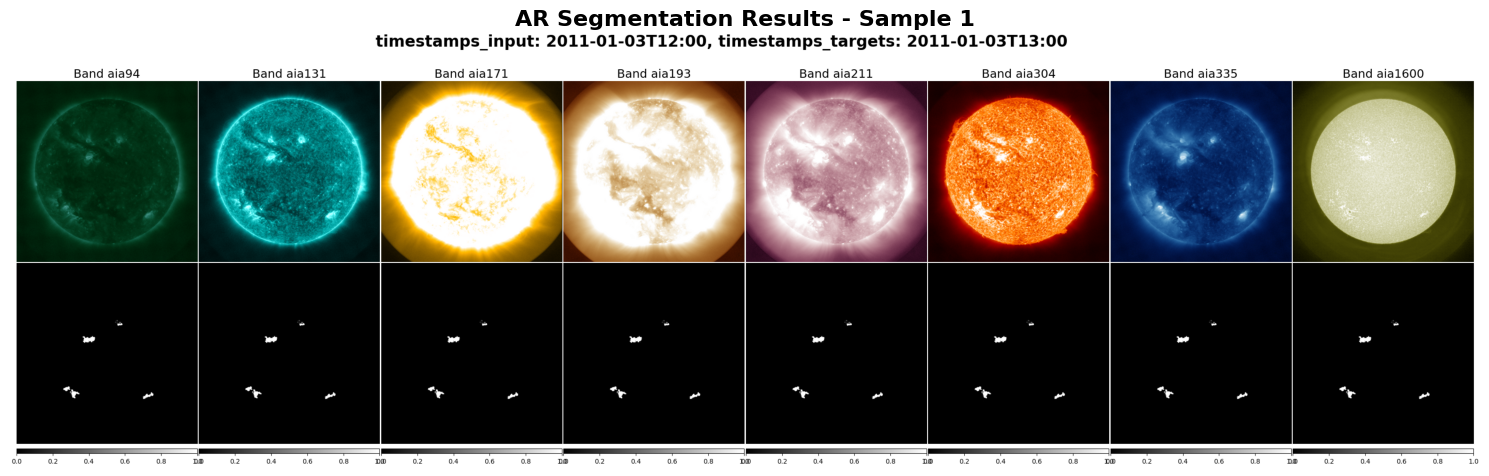

💾 Full path: ./inference_results/test_0.png

🖼️  Sample 2: test_1.png


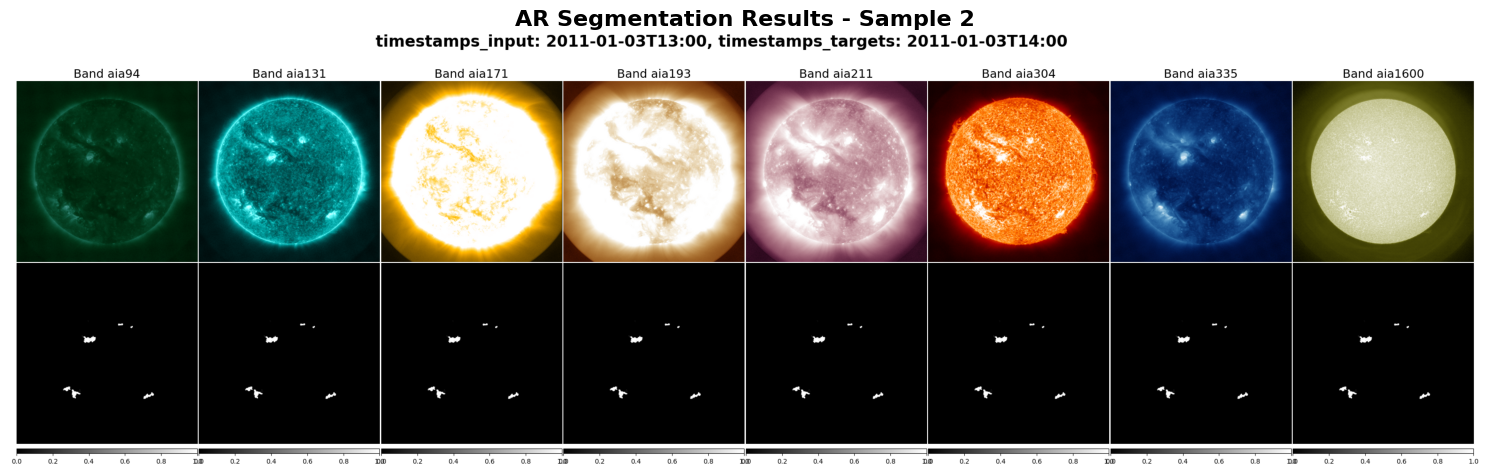

💾 Full path: ./inference_results/test_1.png

🖼️  Sample 3: test_2.png


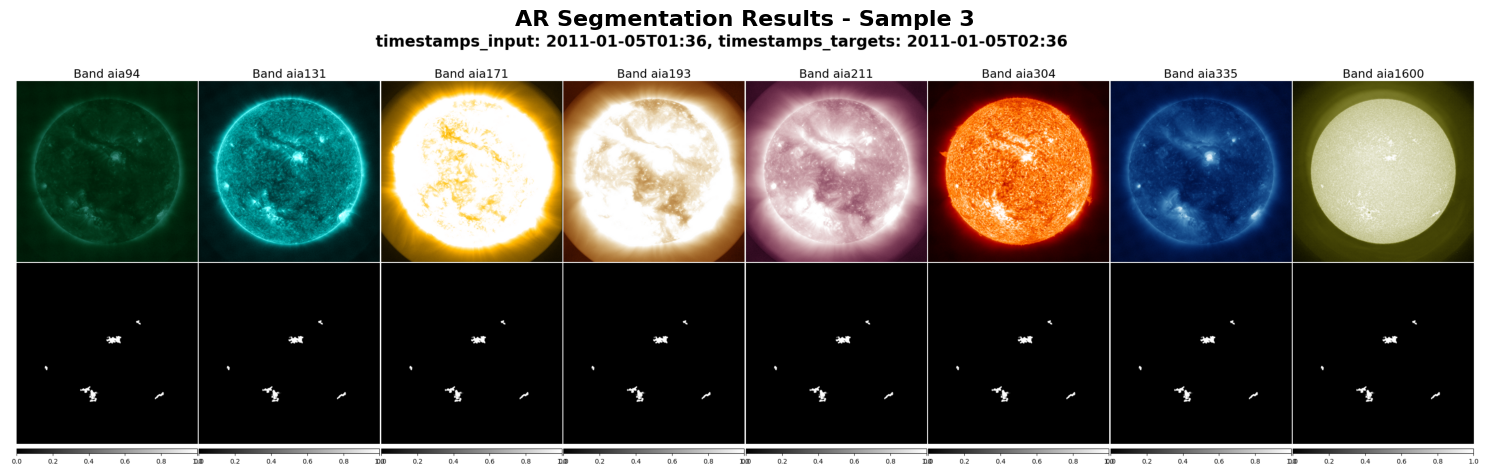

💾 Full path: ./inference_results/test_2.png


In [7]:
import glob
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Find all generated images
image_files = glob.glob(os.path.join(output_dir, "*.png"))
image_files.sort()

if image_files:
    print(f"📸 Found {len(image_files)} result images:")
    
    # Display each image
    for i, img_path in enumerate(image_files):
        print(f"\n🖼️  Sample {i+1}: {os.path.basename(img_path)}")
        
        # Load and display the image
        img = mpimg.imread(img_path)
        plt.figure(figsize=(15, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"AR Segmentation Results - Sample {i+1}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"💾 Full path: {img_path}")
else:
    print("❌ No result images found. Please check if inference ran successfully.")


## Understanding the Results 📊

### What you're seeing:
- **Input images**: The original solar observations from different wavelength channels
- **Prediction**: The model's segmentation of Active Regions (bright areas indicate detected ARs)
- **Multiple channels**: Each column shows different wavelengths of solar observation

### Tips for interpretation:
1. **Bright regions** in the prediction indicate detected Active Regions
2. **Different colors** in input channels show different solar phenomena
3. **Timestamps** show when the observations were taken
4. **Compare** input and prediction to see what the model detected

## Troubleshooting 🔧

### Common issues:
1. **"No config.yaml found"**: Make sure you have the configuration file in your directory
2. **"No data found"**: Check that your data paths in config.yaml are correct
3. **Import errors**: Ensure all required packages are installed

### Need help?
- Check the original `infer.py` file for more details
- Verify your data paths in the configuration
- Make sure you're in the correct directory: `downstream_examples/ar_segmentation/`


## Summary 🎯

Congratulations! You've successfully run AR segmentation inference using the Surya model. 

### What you accomplished:
✅ Downloaded pre-trained model weights  
✅ Loaded and configured the model  
✅ Ran inference on solar data  
✅ Generated and viewed segmentation results  
✅ Learned about customization options  

### Next steps:
- Try different numbers of samples
- Experiment with different data types (test vs valid)
- Explore the generated images in detail
- Check out the original `infer.py` for more advanced usage

### Files generated:
- Results are saved in the `inference_results/` directory
- Each image shows input data and AR segmentation predictions
- Images are named with timestamps for easy identification

Happy solar data analysis! 🌞✨
